### Strong baseline : 0.81410
### ---Public : 0.72819, Private : 0.7089---
### Medium baseline : 0.52807
### Simple baseline : 0.44862
<br>
解題思路:
我覺得semi-supervised learning可以分為兩種標記方式<br>
第一種是強制標記，就是當信心程度到個閥值後就把該資料抓出來，並且從未標記的資料集剔除，放到訓練集裡面<br>
不過這邊要注意一點，就是未標記的資料不能做圖形增強(image augmentation)<br>
你想想看，如果你把未標記的資料增強了，然後它的信心程度是98%，然後放到訓練集裡<br>
訓練集本身也會再做一次圖形增強(image augmentation)，這樣就變成做兩次圖形增強(image augmentation)了<br>
強制標記的優點:因為未標記的資料越來越少，所以每次在跑get_pseudo_labels這個function時會越來越快<br>
強制標記的缺點:怕你標記的圖片是錯的，就這麼一路錯下去，所以閥值要開高點<br>

第二種是彈性標記，就是當每次epoch後就去看哪些未標記圖片的閥值大於你所設定的，然後把它們"暫時"的加入到你的訓練集裡<br>
彈性標記的優點:跟強制標記相比，彈性標記比較不怕標錯圖片的問題，可能幾個epoch後就修正了<br>
彈性標記的缺點:每次在跑get_pseudo_labels這個function都一樣久，運行時間是前者的幾倍起跳<br>

這次的作業我是用強制標記去做的，以後如果有時間我再用彈性標記試試看(跑一次幾個小時就沒了QAQ)<br>

<br>
<p align="center">
Train loss小，Valid loss大，看來需要更多的圖形增強(image augmentation)來彌補loss差距
</p>

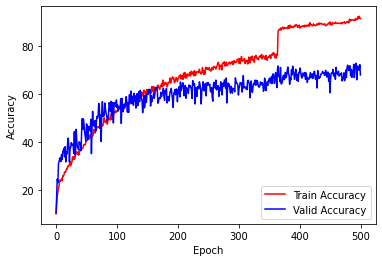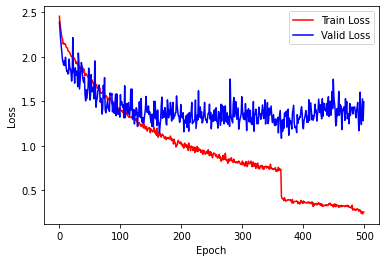

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

import sys
sys.setrecursionlimit(1000000)

# the path where checkpoint saved
model_path = './model.ckpt'

myseed = 123  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

因為我是用強制標記，所以我沒有對unlabeled_set做圖形增強(image augmentation)

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32
test_batch_size = 512

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../input/ml2021spring-hw3/food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("../input/ml2021spring-hw3/food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

因為用DatasetFolder包起來的對象不能進行刪除動作，而且unlabeled_set的的label也沒啥用(都是0)<br>
所以我就用一個list去打包我想要的部分就好，也方便進行刪除

In [ ]:
unlabeled_set_list = []

for img, _ in unlabeled_set:
    unlabeled_set_list.append(img)

In [ ]:
import gc

del valid_set, unlabeled_set, test_set
gc.collect()

21

In [ ]:
def get_pseudo_labels(model, threshold=0.95):
    global unlabeled_set_list, train_set
    
    remove_index, index = [], 0

    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    #device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    #data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for img in tqdm(unlabeled_set_list):

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(torch.unsqueeze(img, 0).cuda())

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        
        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        if torch.max(probs).item() > threshold:
            train_set = ConcatDataset([train_set, ([(img, torch.argmax(probs).item())])])
            remove_index.append(index)
        index += 1
      
    remove_index.reverse()
    for i in remove_index:
        del unlabeled_set_list[i]

    print(f"[{len(train_set)-3080}/6786] images have been labeled.")
    
    # # Turn off the eval mode.
    model.train()

我這邊的思路是當驗證集的acc高於0.7才去抓未標記的圖片<br>
然後當下一次的acc勝過之前的acc才會再做一次抓未標記的圖片的動作(你想想，如果你標記的圖片是對的，沒道理它的acc不會衝的比上一次更高)

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
#model = Classifier().to(device)
model = models.resnet18(pretrained = False)
model.fc = nn.Linear(512, 11)
model.cuda()

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 500
best_acc = 0

valid_acc_last = 0
valid_acc_threshold = 0.7

# Whether to do semi-supervised learning.
#do_semi = True

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if valid_acc_last > valid_acc_threshold:
        
        valid_acc_threshold = valid_acc_last
        
        # Obtain pseudo-labels for unlabeled data using trained model.
        if len(train_set) != 9866: #3080+6786
            get_pseudo_labels(model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))
        
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_acc_last = valid_acc

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('[{:03d}/{:03d}] saving model with acc {:.3f}'.format(epoch + 1, n_epochs, best_acc))

  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 2.45558, acc = 0.09890


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 2.39122, acc = 0.10304

[001/500] saving model with acc 0.103


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 2.36335, acc = 0.13628


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 2.28804, acc = 0.17829

[002/500] saving model with acc 0.178


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 2.32216, acc = 0.17365


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 2.19480, acc = 0.24467

[003/500] saving model with acc 0.245


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 2.27404, acc = 0.19169


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 2.12248, acc = 0.22936


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 2.21410, acc = 0.20780


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 2.04266, acc = 0.30954

[005/500] saving model with acc 0.310


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 2.20619, acc = 0.21585


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 1.96918, acc = 0.31744

[006/500] saving model with acc 0.317


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 2.14456, acc = 0.24001


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 1.93679, acc = 0.33216

[007/500] saving model with acc 0.332


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 2.15570, acc = 0.23550


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 1.90611, acc = 0.33200


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 2.14401, acc = 0.23872


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 1.95470, acc = 0.31812


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 2.14748, acc = 0.24485


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 1.90106, acc = 0.34657

[010/500] saving model with acc 0.347


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 2.13776, acc = 0.23776


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 1.99458, acc = 0.32630


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 2.11135, acc = 0.25838


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 1.88989, acc = 0.35903

[012/500] saving model with acc 0.359


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 2.10254, acc = 0.25612


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 1.83480, acc = 0.36558

[013/500] saving model with acc 0.366


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 2.10022, acc = 0.26256


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 1.84762, acc = 0.37405

[014/500] saving model with acc 0.374


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 2.06790, acc = 0.27416


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 1.80727, acc = 0.33757


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 2.06157, acc = 0.27159


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 1.81170, acc = 0.38031

[016/500] saving model with acc 0.380


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 2.05613, acc = 0.27738


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 1.97462, acc = 0.31654


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 2.04362, acc = 0.28608


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 1.86649, acc = 0.35658


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 2.02494, acc = 0.28544


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 1.86865, acc = 0.34964


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 2.00754, acc = 0.29800


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 1.82843, acc = 0.39696

[020/500] saving model with acc 0.397


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 2.00381, acc = 0.29607


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 1.72687, acc = 0.41633

[021/500] saving model with acc 0.416


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 1.99657, acc = 0.30187


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 1.80964, acc = 0.37970


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 1.96560, acc = 0.30735


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 2.21530, acc = 0.31601


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 1.97488, acc = 0.31862


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 1.82882, acc = 0.37677


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 1.98838, acc = 0.29929


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 1.83065, acc = 0.37661


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 1.97617, acc = 0.30767


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 1.70371, acc = 0.39659


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 1.95917, acc = 0.31572


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 1.87605, acc = 0.38682


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 1.92275, acc = 0.33731


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 1.79203, acc = 0.39036


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 1.94354, acc = 0.32603


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 1.83851, acc = 0.38878


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 1.92547, acc = 0.33924


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 1.82232, acc = 0.35154


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 1.91086, acc = 0.32732


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 1.66265, acc = 0.44315

[031/500] saving model with acc 0.443


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 1.89823, acc = 0.33086


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 2.04242, acc = 0.34544


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 1.90016, acc = 0.34601


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 1.92967, acc = 0.36273


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 1.87004, acc = 0.35889


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 1.63784, acc = 0.45276

[034/500] saving model with acc 0.453


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 1.88508, acc = 0.35406


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 1.74264, acc = 0.40237


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 1.87729, acc = 0.34955


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 1.84823, acc = 0.37938


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 1.85103, acc = 0.35889


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 1.93568, acc = 0.37408


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 1.87996, acc = 0.34472


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 1.89612, acc = 0.36640


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 1.88281, acc = 0.35052


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 1.78256, acc = 0.40065


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 1.82784, acc = 0.36952


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 1.72965, acc = 0.38983


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 1.86351, acc = 0.36405


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 1.71048, acc = 0.39720


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 1.83136, acc = 0.37693


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 1.76882, acc = 0.36349


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 1.78605, acc = 0.37307


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 1.57409, acc = 0.44571


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 1.81103, acc = 0.37274


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 1.50431, acc = 0.49736

[044/500] saving model with acc 0.497


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 1.80780, acc = 0.37210


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 1.62866, acc = 0.45291


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 1.79510, acc = 0.38660


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 1.53177, acc = 0.49630


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 1.78428, acc = 0.38950


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 1.59464, acc = 0.46651


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 1.77069, acc = 0.38789


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 1.65675, acc = 0.43887


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 1.76161, acc = 0.38789


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 1.87225, acc = 0.42122


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 1.75107, acc = 0.40432


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 1.78482, acc = 0.40208


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 1.75405, acc = 0.40496


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 1.51392, acc = 0.47567


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 1.73393, acc = 0.40593


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 1.56880, acc = 0.46838


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 1.72580, acc = 0.40947


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 1.79974, acc = 0.40997


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 1.74226, acc = 0.41366


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 1.60994, acc = 0.46455


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 1.71827, acc = 0.41366


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 1.60663, acc = 0.46410


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 1.71832, acc = 0.41269


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 1.62444, acc = 0.45291


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 1.68607, acc = 0.43009


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 1.66820, acc = 0.44668


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 1.70691, acc = 0.42010


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 1.52601, acc = 0.49459


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 1.70103, acc = 0.42236


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 1.95363, acc = 0.35093


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 1.69608, acc = 0.42107


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 1.66291, acc = 0.45719


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 1.67997, acc = 0.42494


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 1.43360, acc = 0.52808

[061/500] saving model with acc 0.528


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 1.68562, acc = 0.43106


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 1.50840, acc = 0.47057


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 1.64511, acc = 0.45232


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 1.53579, acc = 0.48490


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 1.65062, acc = 0.44008


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 1.62103, acc = 0.46366


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 1.65905, acc = 0.43718


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 1.63162, acc = 0.48926


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 1.63385, acc = 0.45780


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 1.68352, acc = 0.44449


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 1.65075, acc = 0.45006


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 1.61166, acc = 0.47559


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 1.60007, acc = 0.46166


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 1.49082, acc = 0.50736


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 1.59090, acc = 0.46327


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 1.53406, acc = 0.49894


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 1.58830, acc = 0.46037


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 1.49529, acc = 0.51014


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 1.59872, acc = 0.46327


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 1.35606, acc = 0.56134

[071/500] saving model with acc 0.561


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 1.59713, acc = 0.46327


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 1.42731, acc = 0.54392


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 1.61254, acc = 0.45683


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 1.67938, acc = 0.45690


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 1.58563, acc = 0.46939


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 1.54060, acc = 0.51275


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 1.57070, acc = 0.46714


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 1.76634, acc = 0.40155


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 1.54534, acc = 0.46972


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 1.40744, acc = 0.52523


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 1.55631, acc = 0.46617


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 1.37051, acc = 0.56841

[077/500] saving model with acc 0.568


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 1.56135, acc = 0.47004


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 1.42197, acc = 0.50647


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 1.54620, acc = 0.48389


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 1.46677, acc = 0.51021


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 1.51233, acc = 0.50097


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 1.51614, acc = 0.50932


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 1.51929, acc = 0.48615


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 1.41887, acc = 0.56276


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 1.53680, acc = 0.48099


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 1.40732, acc = 0.53748


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 1.52220, acc = 0.48228


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 1.38650, acc = 0.52096


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 1.51727, acc = 0.49259


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 1.59363, acc = 0.51156


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 1.54023, acc = 0.47423


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 1.57208, acc = 0.48889


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 1.50866, acc = 0.48679


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 1.56510, acc = 0.50158


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 1.47046, acc = 0.50741


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 1.58711, acc = 0.50992


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 1.49709, acc = 0.49581


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 1.38202, acc = 0.56406


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 1.49535, acc = 0.49485


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 1.41746, acc = 0.55783


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 1.48051, acc = 0.49195


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 1.47879, acc = 0.52869


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 1.45837, acc = 0.51095


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 1.36497, acc = 0.56984

[091/500] saving model with acc 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 1.44893, acc = 0.51772


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 1.47533, acc = 0.51293


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 1.47784, acc = 0.49356


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 1.58091, acc = 0.50924


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 1.41238, acc = 0.52384


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 1.33747, acc = 0.56556


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 1.44132, acc = 0.51192


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 1.58310, acc = 0.47920


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 1.43614, acc = 0.52642


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 1.42095, acc = 0.54476


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 1.41216, acc = 0.52513


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 1.35370, acc = 0.56443


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 1.41975, acc = 0.52159


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 1.40348, acc = 0.55836


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 1.39169, acc = 0.53061


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 1.39182, acc = 0.54896


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 1.42702, acc = 0.52513


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 1.32209, acc = 0.57554

[100/500] saving model with acc 0.576


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 1.39927, acc = 0.53125


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 1.57369, acc = 0.54310


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 1.40140, acc = 0.52706


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 1.46040, acc = 0.55519


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 1.38558, acc = 0.54220


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 1.49700, acc = 0.53019


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 1.39648, acc = 0.54253


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 1.46235, acc = 0.54424


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 1.36943, acc = 0.54897


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 1.42986, acc = 0.54492


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 1.37180, acc = 0.54253


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 1.45754, acc = 0.53740


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 1.39601, acc = 0.53866


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 1.31324, acc = 0.58058

[107/500] saving model with acc 0.581


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 1.38871, acc = 0.54156


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 1.67453, acc = 0.47709


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 1.35587, acc = 0.54220


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 1.31689, acc = 0.58261

[109/500] saving model with acc 0.583


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 1.34995, acc = 0.54607


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 1.47309, acc = 0.53793


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 1.37205, acc = 0.53802


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 1.47019, acc = 0.52666


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 1.36141, acc = 0.53640


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 1.39074, acc = 0.55714


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 1.33854, acc = 0.54768


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 1.36668, acc = 0.54273


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 1.33175, acc = 0.56024


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 1.48374, acc = 0.54289


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 1.31837, acc = 0.55026


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 1.36767, acc = 0.56556


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 1.32931, acc = 0.55992


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 1.34210, acc = 0.58950

[116/500] saving model with acc 0.590


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 1.32323, acc = 0.55670


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 1.42214, acc = 0.56503


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 1.31744, acc = 0.56540


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 1.63664, acc = 0.52478


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 1.32554, acc = 0.55735


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 1.40255, acc = 0.56422


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 1.33236, acc = 0.55735


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 1.63790, acc = 0.52365


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 1.29387, acc = 0.56411


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 1.30321, acc = 0.59649

[121/500] saving model with acc 0.596


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 1.32447, acc = 0.55896


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 1.31335, acc = 0.59800

[122/500] saving model with acc 0.598


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 1.30810, acc = 0.56186


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 1.40667, acc = 0.56609


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 1.30951, acc = 0.56218


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 1.24588, acc = 0.61294

[124/500] saving model with acc 0.613


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 1.29380, acc = 0.56830


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 1.39884, acc = 0.56007


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 1.28715, acc = 0.57474


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 1.34792, acc = 0.59177


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 1.30459, acc = 0.56765


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 1.42750, acc = 0.56459


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 1.26856, acc = 0.57893


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 1.40880, acc = 0.55324


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 1.26572, acc = 0.57313


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 1.21766, acc = 0.60341


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 1.22551, acc = 0.59311


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 1.36990, acc = 0.57029


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 1.25956, acc = 0.57957


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 1.33143, acc = 0.59238


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 1.25940, acc = 0.57700


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 1.49412, acc = 0.54154


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 1.24519, acc = 0.58570


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 1.35332, acc = 0.56031


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 1.22655, acc = 0.59794


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 1.31681, acc = 0.60243


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 135/500 ] loss = 1.21759, acc = 0.59149


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 135/500 ] loss = 1.53096, acc = 0.55144


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 136/500 ] loss = 1.23635, acc = 0.59117


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 136/500 ] loss = 1.28413, acc = 0.58794


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 137/500 ] loss = 1.24681, acc = 0.58860


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 137/500 ] loss = 1.26103, acc = 0.61054


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 138/500 ] loss = 1.21199, acc = 0.59987


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 138/500 ] loss = 1.31671, acc = 0.56833


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 139/500 ] loss = 1.20007, acc = 0.59246


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 139/500 ] loss = 1.25281, acc = 0.61587

[139/500] saving model with acc 0.616


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 140/500 ] loss = 1.24397, acc = 0.59246


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 140/500 ] loss = 1.29633, acc = 0.60573


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 141/500 ] loss = 1.21386, acc = 0.60535


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 141/500 ] loss = 1.36305, acc = 0.58509


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 142/500 ] loss = 1.18752, acc = 0.60857


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 142/500 ] loss = 1.41723, acc = 0.57224


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 143/500 ] loss = 1.21067, acc = 0.59182


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 143/500 ] loss = 1.55405, acc = 0.52238


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 144/500 ] loss = 1.21514, acc = 0.59246


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 144/500 ] loss = 1.42137, acc = 0.56129


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 145/500 ] loss = 1.16552, acc = 0.61695


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 145/500 ] loss = 1.37397, acc = 0.59584


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 146/500 ] loss = 1.18639, acc = 0.61437


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 146/500 ] loss = 1.40529, acc = 0.54281


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 147/500 ] loss = 1.19225, acc = 0.60857


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 147/500 ] loss = 1.44779, acc = 0.56292


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 148/500 ] loss = 1.20609, acc = 0.59536


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 148/500 ] loss = 1.35195, acc = 0.59454


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 149/500 ] loss = 1.20126, acc = 0.60567


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 149/500 ] loss = 1.38259, acc = 0.56511


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 150/500 ] loss = 1.14659, acc = 0.61985


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 150/500 ] loss = 1.31639, acc = 0.59673


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 151/500 ] loss = 1.19094, acc = 0.60857


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 151/500 ] loss = 1.26084, acc = 0.60536


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 152/500 ] loss = 1.17798, acc = 0.60728


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 152/500 ] loss = 1.35346, acc = 0.59861


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 153/500 ] loss = 1.16705, acc = 0.61244


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 153/500 ] loss = 1.21658, acc = 0.61933

[153/500] saving model with acc 0.619


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 154/500 ] loss = 1.15602, acc = 0.61985


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 154/500 ] loss = 1.35437, acc = 0.60964


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 155/500 ] loss = 1.16312, acc = 0.61405


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 155/500 ] loss = 1.21434, acc = 0.61962

[155/500] saving model with acc 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 156/500 ] loss = 1.20439, acc = 0.60084


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 156/500 ] loss = 1.50186, acc = 0.55010


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 157/500 ] loss = 1.16875, acc = 0.60696


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 157/500 ] loss = 1.31506, acc = 0.59343


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 158/500 ] loss = 1.14151, acc = 0.63112


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 158/500 ] loss = 1.49783, acc = 0.56825


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 159/500 ] loss = 1.17151, acc = 0.61147


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 159/500 ] loss = 1.30122, acc = 0.58298


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 160/500 ] loss = 1.11869, acc = 0.63144


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 160/500 ] loss = 1.38632, acc = 0.58913


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 161/500 ] loss = 1.19879, acc = 0.60309


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 161/500 ] loss = 1.22939, acc = 0.60198


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 162/500 ] loss = 1.13404, acc = 0.62919


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 162/500 ] loss = 1.40236, acc = 0.58216


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 163/500 ] loss = 1.09571, acc = 0.62758


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 163/500 ] loss = 1.27584, acc = 0.59921


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 164/500 ] loss = 1.14446, acc = 0.61372


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 164/500 ] loss = 1.25185, acc = 0.62563

[164/500] saving model with acc 0.626


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 165/500 ] loss = 1.12217, acc = 0.62436


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 165/500 ] loss = 1.14808, acc = 0.62751

[165/500] saving model with acc 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 166/500 ] loss = 1.14227, acc = 0.61534


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 166/500 ] loss = 1.22263, acc = 0.62901

[166/500] saving model with acc 0.629


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 167/500 ] loss = 1.11328, acc = 0.63048


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 167/500 ] loss = 1.29877, acc = 0.61790


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 168/500 ] loss = 1.09654, acc = 0.63789


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 168/500 ] loss = 1.45536, acc = 0.56173


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 169/500 ] loss = 1.12413, acc = 0.62822


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 169/500 ] loss = 1.54786, acc = 0.56857


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 170/500 ] loss = 1.13067, acc = 0.62500


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 170/500 ] loss = 1.30998, acc = 0.58314


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 171/500 ] loss = 1.11948, acc = 0.61920


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 171/500 ] loss = 1.35447, acc = 0.58599


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 172/500 ] loss = 1.10905, acc = 0.63499


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 172/500 ] loss = 1.39685, acc = 0.58119


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 173/500 ] loss = 1.08222, acc = 0.63241


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 173/500 ] loss = 1.32167, acc = 0.60784


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 174/500 ] loss = 1.08905, acc = 0.64304


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 174/500 ] loss = 1.42885, acc = 0.58982


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 175/500 ] loss = 1.10182, acc = 0.63015


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 175/500 ] loss = 1.35807, acc = 0.59958


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 176/500 ] loss = 1.06895, acc = 0.65883


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 176/500 ] loss = 1.24168, acc = 0.60837


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 177/500 ] loss = 1.08712, acc = 0.63466


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 177/500 ] loss = 1.23449, acc = 0.62466


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 178/500 ] loss = 1.08124, acc = 0.64207


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 178/500 ] loss = 1.51572, acc = 0.58779


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 179/500 ] loss = 1.09384, acc = 0.63982


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 179/500 ] loss = 1.45211, acc = 0.57382


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 180/500 ] loss = 1.08838, acc = 0.64948


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 180/500 ] loss = 1.31385, acc = 0.61497


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 181/500 ] loss = 1.07747, acc = 0.64175


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 181/500 ] loss = 1.39832, acc = 0.60288


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 182/500 ] loss = 1.07564, acc = 0.64626


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 182/500 ] loss = 1.34850, acc = 0.62392


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 183/500 ] loss = 1.10952, acc = 0.62983


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 183/500 ] loss = 1.48712, acc = 0.56292


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 184/500 ] loss = 1.08271, acc = 0.63982


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 184/500 ] loss = 1.38641, acc = 0.58860


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 185/500 ] loss = 1.05724, acc = 0.64916


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 185/500 ] loss = 1.27802, acc = 0.58982


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 186/500 ] loss = 1.07460, acc = 0.64852


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 186/500 ] loss = 1.39897, acc = 0.57126


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 187/500 ] loss = 1.07559, acc = 0.64852


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 187/500 ] loss = 1.48853, acc = 0.59064


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 188/500 ] loss = 1.01958, acc = 0.66720


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 188/500 ] loss = 1.30129, acc = 0.61069


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 189/500 ] loss = 1.07192, acc = 0.64594


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 189/500 ] loss = 1.34821, acc = 0.61091


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 190/500 ] loss = 1.03864, acc = 0.66527


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 190/500 ] loss = 1.33408, acc = 0.62384


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 191/500 ] loss = 1.03321, acc = 0.66334


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 191/500 ] loss = 1.37175, acc = 0.59771


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 192/500 ] loss = 0.98587, acc = 0.67204


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 192/500 ] loss = 1.36926, acc = 0.57736


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 193/500 ] loss = 1.00257, acc = 0.66495


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 193/500 ] loss = 1.56046, acc = 0.54424


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 194/500 ] loss = 1.00499, acc = 0.66753


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 194/500 ] loss = 1.45348, acc = 0.60154


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 195/500 ] loss = 1.04786, acc = 0.64852


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 195/500 ] loss = 1.38831, acc = 0.60866


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 196/500 ] loss = 1.06065, acc = 0.65045


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 196/500 ] loss = 1.33627, acc = 0.61940


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 197/500 ] loss = 1.04232, acc = 0.66012


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 197/500 ] loss = 1.33518, acc = 0.59673


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 198/500 ] loss = 1.02986, acc = 0.67010


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 198/500 ] loss = 1.26313, acc = 0.62120


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 199/500 ] loss = 1.02520, acc = 0.66140


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 199/500 ] loss = 1.28989, acc = 0.62091


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 200/500 ] loss = 1.04335, acc = 0.65238


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 200/500 ] loss = 1.46328, acc = 0.56820


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 201/500 ] loss = 1.01231, acc = 0.66656


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 201/500 ] loss = 1.32194, acc = 0.61896


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 202/500 ] loss = 1.02215, acc = 0.66591


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 202/500 ] loss = 1.36480, acc = 0.60222


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 203/500 ] loss = 0.99378, acc = 0.67719


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 203/500 ] loss = 1.31006, acc = 0.63141

[203/500] saving model with acc 0.631


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 204/500 ] loss = 1.00665, acc = 0.67526


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 204/500 ] loss = 1.37087, acc = 0.58794


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 205/500 ] loss = 0.97298, acc = 0.68106


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 205/500 ] loss = 1.15707, acc = 0.65087

[205/500] saving model with acc 0.651


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 206/500 ] loss = 1.03017, acc = 0.66302


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 206/500 ] loss = 1.28806, acc = 0.61370


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 207/500 ] loss = 1.02209, acc = 0.67655


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 207/500 ] loss = 1.26834, acc = 0.62091


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 208/500 ] loss = 0.99030, acc = 0.67526


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 208/500 ] loss = 1.25497, acc = 0.63772


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 209/500 ] loss = 1.01278, acc = 0.66140


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 209/500 ] loss = 1.33831, acc = 0.64749


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 210/500 ] loss = 0.97911, acc = 0.68750


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 210/500 ] loss = 1.20781, acc = 0.63593


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 211/500 ] loss = 1.00470, acc = 0.66978


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 211/500 ] loss = 1.35551, acc = 0.59283


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 212/500 ] loss = 0.94944, acc = 0.69072


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 212/500 ] loss = 1.28044, acc = 0.63165


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 213/500 ] loss = 1.03095, acc = 0.66753


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 213/500 ] loss = 1.16415, acc = 0.63585


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 214/500 ] loss = 0.98497, acc = 0.67526


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 214/500 ] loss = 1.37409, acc = 0.58269


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 215/500 ] loss = 0.98916, acc = 0.66753


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 215/500 ] loss = 1.26189, acc = 0.62759


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 216/500 ] loss = 0.94504, acc = 0.68492


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 216/500 ] loss = 1.32728, acc = 0.61753


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 217/500 ] loss = 0.99774, acc = 0.67687


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 217/500 ] loss = 1.37441, acc = 0.61700


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 218/500 ] loss = 0.99289, acc = 0.67655


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 218/500 ] loss = 1.48704, acc = 0.60228


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 219/500 ] loss = 0.98492, acc = 0.67912


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 219/500 ] loss = 1.24844, acc = 0.63833


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 220/500 ] loss = 0.94679, acc = 0.69104


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 220/500 ] loss = 1.26987, acc = 0.63096


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 221/500 ] loss = 0.98551, acc = 0.67526


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 221/500 ] loss = 1.26429, acc = 0.63572


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 222/500 ] loss = 0.98308, acc = 0.68299


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 222/500 ] loss = 1.28663, acc = 0.62999


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 223/500 ] loss = 0.92392, acc = 0.69620


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 223/500 ] loss = 1.30631, acc = 0.61700


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 224/500 ] loss = 0.98136, acc = 0.68363


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 224/500 ] loss = 1.51456, acc = 0.58171


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 225/500 ] loss = 0.97329, acc = 0.68557


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 225/500 ] loss = 1.19449, acc = 0.65628

[225/500] saving model with acc 0.656


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 226/500 ] loss = 0.93985, acc = 0.69233


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 226/500 ] loss = 1.26961, acc = 0.65124


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 227/500 ] loss = 0.99327, acc = 0.67622


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 227/500 ] loss = 1.34618, acc = 0.63601


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 228/500 ] loss = 0.93421, acc = 0.69813


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 228/500 ] loss = 1.29144, acc = 0.64260


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 229/500 ] loss = 0.97597, acc = 0.67784


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 229/500 ] loss = 1.61796, acc = 0.55873


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 230/500 ] loss = 0.95532, acc = 0.67784


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 230/500 ] loss = 1.32189, acc = 0.62714


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 231/500 ] loss = 0.95129, acc = 0.69265


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 231/500 ] loss = 1.32827, acc = 0.62278


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 232/500 ] loss = 0.95920, acc = 0.69427


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 232/500 ] loss = 1.43641, acc = 0.59042


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 233/500 ] loss = 0.92478, acc = 0.69362


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 233/500 ] loss = 1.31089, acc = 0.63149


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 234/500 ] loss = 0.93617, acc = 0.68943


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 234/500 ] loss = 1.38314, acc = 0.62751


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 235/500 ] loss = 0.95159, acc = 0.68976


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 235/500 ] loss = 1.25674, acc = 0.62241


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 236/500 ] loss = 0.90403, acc = 0.70425


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 236/500 ] loss = 1.27039, acc = 0.65139


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 237/500 ] loss = 0.94699, acc = 0.69330


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 237/500 ] loss = 1.32281, acc = 0.64057


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 238/500 ] loss = 0.92656, acc = 0.68847


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 238/500 ] loss = 1.37478, acc = 0.62278


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 239/500 ] loss = 0.94198, acc = 0.68363


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 239/500 ] loss = 1.48702, acc = 0.55880


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 240/500 ] loss = 0.90390, acc = 0.69040


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 240/500 ] loss = 1.32093, acc = 0.61355


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 241/500 ] loss = 0.91272, acc = 0.71134


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 241/500 ] loss = 1.28916, acc = 0.62038


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 242/500 ] loss = 0.92165, acc = 0.69878


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 242/500 ] loss = 1.29097, acc = 0.65168


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 243/500 ] loss = 0.93677, acc = 0.68202


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 243/500 ] loss = 1.25839, acc = 0.64073


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 244/500 ] loss = 0.91245, acc = 0.69813


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 244/500 ] loss = 1.32261, acc = 0.61310


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 245/500 ] loss = 0.95549, acc = 0.68396


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 245/500 ] loss = 1.36633, acc = 0.63540


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 246/500 ] loss = 0.90838, acc = 0.70973


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 246/500 ] loss = 1.35569, acc = 0.64456


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 247/500 ] loss = 0.88894, acc = 0.71231


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 247/500 ] loss = 1.46770, acc = 0.59254


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 248/500 ] loss = 0.93507, acc = 0.70425


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 248/500 ] loss = 1.30095, acc = 0.64651


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 249/500 ] loss = 0.89367, acc = 0.70973


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 249/500 ] loss = 1.37327, acc = 0.63682


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 250/500 ] loss = 0.92445, acc = 0.70393


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 250/500 ] loss = 1.19085, acc = 0.64883


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 251/500 ] loss = 0.88728, acc = 0.70200


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 251/500 ] loss = 1.30123, acc = 0.64126


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 252/500 ] loss = 0.86499, acc = 0.71102


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 252/500 ] loss = 1.34666, acc = 0.63630


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 253/500 ] loss = 0.90365, acc = 0.70168


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 253/500 ] loss = 1.27517, acc = 0.64110


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 254/500 ] loss = 0.91985, acc = 0.69845


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 254/500 ] loss = 1.37322, acc = 0.61273


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 255/500 ] loss = 0.91354, acc = 0.69620


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 255/500 ] loss = 1.40178, acc = 0.60919


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 256/500 ] loss = 0.91067, acc = 0.70683


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 256/500 ] loss = 1.28262, acc = 0.62751


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 257/500 ] loss = 0.88280, acc = 0.71134


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 257/500 ] loss = 1.41456, acc = 0.58847


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 258/500 ] loss = 0.90074, acc = 0.70232


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 258/500 ] loss = 1.42726, acc = 0.57044


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 259/500 ] loss = 0.89217, acc = 0.70876


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 259/500 ] loss = 1.27252, acc = 0.63833


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 260/500 ] loss = 0.86199, acc = 0.71649


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 260/500 ] loss = 1.26608, acc = 0.64899


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 261/500 ] loss = 0.86619, acc = 0.71327


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 261/500 ] loss = 1.19859, acc = 0.63060


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 262/500 ] loss = 0.88100, acc = 0.71263


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 262/500 ] loss = 1.38522, acc = 0.62505


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 263/500 ] loss = 0.90443, acc = 0.70490


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 263/500 ] loss = 1.30867, acc = 0.65868

[263/500] saving model with acc 0.659


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 264/500 ] loss = 0.86002, acc = 0.71295


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 264/500 ] loss = 1.35657, acc = 0.61782


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 265/500 ] loss = 0.87411, acc = 0.71778


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 265/500 ] loss = 1.23027, acc = 0.63442


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 266/500 ] loss = 0.82640, acc = 0.72874


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 266/500 ] loss = 1.46716, acc = 0.62165


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 267/500 ] loss = 0.83593, acc = 0.73293


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 267/500 ] loss = 1.27727, acc = 0.63479


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 268/500 ] loss = 0.84978, acc = 0.72519


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 268/500 ] loss = 1.45490, acc = 0.59079


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 269/500 ] loss = 0.89402, acc = 0.70296


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 269/500 ] loss = 1.41569, acc = 0.62616


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 270/500 ] loss = 0.84298, acc = 0.71972


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 270/500 ] loss = 1.43675, acc = 0.61407


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 271/500 ] loss = 0.86034, acc = 0.72036


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 271/500 ] loss = 1.24662, acc = 0.65147


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 272/500 ] loss = 0.85394, acc = 0.72068


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 272/500 ] loss = 1.40937, acc = 0.63202


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 273/500 ] loss = 0.91653, acc = 0.70103


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 273/500 ] loss = 1.44849, acc = 0.59636


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 274/500 ] loss = 0.83954, acc = 0.72938


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 274/500 ] loss = 1.27450, acc = 0.63007


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 275/500 ] loss = 0.84344, acc = 0.72874


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 275/500 ] loss = 1.26629, acc = 0.64614


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 276/500 ] loss = 0.83128, acc = 0.73228


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 276/500 ] loss = 1.37016, acc = 0.63255


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 277/500 ] loss = 0.80272, acc = 0.73550


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 277/500 ] loss = 1.24284, acc = 0.65950

[277/500] saving model with acc 0.659


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 278/500 ] loss = 0.85191, acc = 0.71682


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 278/500 ] loss = 1.27735, acc = 0.64313


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 279/500 ] loss = 0.82525, acc = 0.72680


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 279/500 ] loss = 1.33511, acc = 0.62482


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 280/500 ] loss = 0.83171, acc = 0.73421


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 280/500 ] loss = 1.21706, acc = 0.66747

[280/500] saving model with acc 0.667


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 281/500 ] loss = 0.85682, acc = 0.71811


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 281/500 ] loss = 1.75055, acc = 0.56287


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 282/500 ] loss = 0.83635, acc = 0.72294


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 282/500 ] loss = 1.36641, acc = 0.61452


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 283/500 ] loss = 0.86547, acc = 0.72487


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 283/500 ] loss = 1.30503, acc = 0.64622


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 284/500 ] loss = 0.82607, acc = 0.73099


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 284/500 ] loss = 1.28340, acc = 0.63556


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 285/500 ] loss = 0.83365, acc = 0.73389


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 285/500 ] loss = 1.25846, acc = 0.64171


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 286/500 ] loss = 0.81160, acc = 0.72713


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 286/500 ] loss = 1.46890, acc = 0.62054


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 287/500 ] loss = 0.84933, acc = 0.72616


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 287/500 ] loss = 1.54280, acc = 0.60431


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 288/500 ] loss = 0.81970, acc = 0.73260


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 288/500 ] loss = 1.32634, acc = 0.63247


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 289/500 ] loss = 0.81630, acc = 0.72841


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 289/500 ] loss = 1.37566, acc = 0.62189


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 290/500 ] loss = 0.80849, acc = 0.73679


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 290/500 ] loss = 1.49833, acc = 0.60402


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 291/500 ] loss = 0.82189, acc = 0.72326


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 291/500 ] loss = 1.43066, acc = 0.62474


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 292/500 ] loss = 0.82038, acc = 0.73003


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 292/500 ] loss = 1.29698, acc = 0.62226


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 293/500 ] loss = 0.80599, acc = 0.74001


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 293/500 ] loss = 1.36686, acc = 0.62038


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 294/500 ] loss = 0.81308, acc = 0.73099


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 294/500 ] loss = 1.42568, acc = 0.60927


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 295/500 ] loss = 0.82881, acc = 0.73228


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 295/500 ] loss = 1.18686, acc = 0.66792

[295/500] saving model with acc 0.668


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 296/500 ] loss = 0.81662, acc = 0.73647


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 296/500 ] loss = 1.25755, acc = 0.65387


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 297/500 ] loss = 0.80688, acc = 0.73421


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 297/500 ] loss = 1.29634, acc = 0.64569


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 298/500 ] loss = 0.79446, acc = 0.74452


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 298/500 ] loss = 1.32406, acc = 0.64516


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 299/500 ] loss = 0.80147, acc = 0.74678


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 299/500 ] loss = 1.35909, acc = 0.63743


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 300/500 ] loss = 0.79048, acc = 0.74646


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 300/500 ] loss = 1.55119, acc = 0.59605


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 301/500 ] loss = 0.82836, acc = 0.72906


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 301/500 ] loss = 1.42595, acc = 0.62323


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 302/500 ] loss = 0.78497, acc = 0.74936


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 302/500 ] loss = 1.32900, acc = 0.63482


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 303/500 ] loss = 0.80734, acc = 0.72713


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 303/500 ] loss = 1.29936, acc = 0.64862


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 304/500 ] loss = 0.80421, acc = 0.74034


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 304/500 ] loss = 1.36508, acc = 0.64509


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 305/500 ] loss = 0.77062, acc = 0.75741


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 305/500 ] loss = 1.29205, acc = 0.64606


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 306/500 ] loss = 0.78353, acc = 0.74581


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 306/500 ] loss = 1.47367, acc = 0.60845


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 307/500 ] loss = 0.82349, acc = 0.73776


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 307/500 ] loss = 1.34136, acc = 0.62767


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 308/500 ] loss = 0.80191, acc = 0.74098


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 308/500 ] loss = 1.17077, acc = 0.67744

[308/500] saving model with acc 0.677


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 309/500 ] loss = 0.76562, acc = 0.74485


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 309/500 ] loss = 1.39767, acc = 0.62632


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 310/500 ] loss = 0.80221, acc = 0.74871


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 310/500 ] loss = 1.32940, acc = 0.62999


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 311/500 ] loss = 0.82752, acc = 0.72777


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 311/500 ] loss = 1.41740, acc = 0.62738


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 312/500 ] loss = 0.80280, acc = 0.74034


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 312/500 ] loss = 1.26835, acc = 0.62249


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 313/500 ] loss = 0.79694, acc = 0.74034


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 313/500 ] loss = 1.37209, acc = 0.63112


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 314/500 ] loss = 0.79975, acc = 0.74162


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 314/500 ] loss = 1.39863, acc = 0.61867


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 315/500 ] loss = 0.82816, acc = 0.72648


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 315/500 ] loss = 1.25640, acc = 0.65620


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 316/500 ] loss = 0.82115, acc = 0.72745


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 316/500 ] loss = 1.31492, acc = 0.65786


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 317/500 ] loss = 0.76400, acc = 0.75515


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 317/500 ] loss = 1.23785, acc = 0.64915


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 318/500 ] loss = 0.80068, acc = 0.74162


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 318/500 ] loss = 1.30957, acc = 0.64208


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 319/500 ] loss = 0.81663, acc = 0.73067


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 319/500 ] loss = 1.49682, acc = 0.58480


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 320/500 ] loss = 0.76825, acc = 0.75451


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 320/500 ] loss = 1.16363, acc = 0.64073


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 321/500 ] loss = 0.79282, acc = 0.75515


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 321/500 ] loss = 1.34216, acc = 0.65514


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 322/500 ] loss = 0.80184, acc = 0.74227


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 322/500 ] loss = 1.35870, acc = 0.61281


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 323/500 ] loss = 0.74675, acc = 0.75902


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 323/500 ] loss = 1.41120, acc = 0.60695


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 324/500 ] loss = 0.79482, acc = 0.74259


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 324/500 ] loss = 1.36832, acc = 0.63247


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 325/500 ] loss = 0.76812, acc = 0.74195


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 325/500 ] loss = 1.24674, acc = 0.64480


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 326/500 ] loss = 0.80548, acc = 0.73325


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 326/500 ] loss = 1.31556, acc = 0.64126


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 327/500 ] loss = 0.74804, acc = 0.75838


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 327/500 ] loss = 1.24741, acc = 0.65831


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 328/500 ] loss = 0.77330, acc = 0.75322


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 328/500 ] loss = 1.43455, acc = 0.63735


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 329/500 ] loss = 0.73916, acc = 0.76160


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 329/500 ] loss = 1.35963, acc = 0.65770


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 330/500 ] loss = 0.76018, acc = 0.75354


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 330/500 ] loss = 1.36252, acc = 0.63857


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 331/500 ] loss = 0.77514, acc = 0.74581


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 331/500 ] loss = 1.29785, acc = 0.65657


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 332/500 ] loss = 0.76534, acc = 0.74968


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 332/500 ] loss = 1.30603, acc = 0.64419


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 333/500 ] loss = 0.78066, acc = 0.74356


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 333/500 ] loss = 1.38622, acc = 0.63023


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 334/500 ] loss = 0.74258, acc = 0.75644


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 334/500 ] loss = 1.45951, acc = 0.62909


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 335/500 ] loss = 0.76376, acc = 0.75805


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 335/500 ] loss = 1.38478, acc = 0.63210


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 336/500 ] loss = 0.73474, acc = 0.76095


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 336/500 ] loss = 1.30615, acc = 0.65102


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 337/500 ] loss = 0.76621, acc = 0.75290


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 337/500 ] loss = 1.35369, acc = 0.64809


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 338/500 ] loss = 0.76156, acc = 0.76643


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 338/500 ] loss = 1.51604, acc = 0.63886


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 339/500 ] loss = 0.77127, acc = 0.74710


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 339/500 ] loss = 1.24432, acc = 0.64794


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 340/500 ] loss = 0.77126, acc = 0.75451


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 340/500 ] loss = 1.34969, acc = 0.64134


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 341/500 ] loss = 0.74879, acc = 0.75999


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 341/500 ] loss = 1.36732, acc = 0.61183


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 342/500 ] loss = 0.76703, acc = 0.75548


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 342/500 ] loss = 1.48594, acc = 0.61859


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 343/500 ] loss = 0.76095, acc = 0.75451


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 343/500 ] loss = 1.24876, acc = 0.66670


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 344/500 ] loss = 0.76465, acc = 0.74485


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 344/500 ] loss = 1.28404, acc = 0.65042


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 345/500 ] loss = 0.73608, acc = 0.76224


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 345/500 ] loss = 1.42325, acc = 0.61481


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 346/500 ] loss = 0.74666, acc = 0.75644


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 346/500 ] loss = 1.34620, acc = 0.64831


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 347/500 ] loss = 0.79315, acc = 0.74162


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 347/500 ] loss = 1.39436, acc = 0.65050


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 348/500 ] loss = 0.74451, acc = 0.75161


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 348/500 ] loss = 1.44714, acc = 0.63577


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 349/500 ] loss = 0.74991, acc = 0.75580


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 349/500 ] loss = 1.34752, acc = 0.65680


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 350/500 ] loss = 0.73848, acc = 0.75354


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 350/500 ] loss = 1.26088, acc = 0.65680


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 351/500 ] loss = 0.74072, acc = 0.76289


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 351/500 ] loss = 1.30688, acc = 0.66702


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 352/500 ] loss = 0.73165, acc = 0.75934


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 352/500 ] loss = 1.34909, acc = 0.64614


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 353/500 ] loss = 0.74183, acc = 0.74968


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 353/500 ] loss = 1.25267, acc = 0.65965


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 354/500 ] loss = 0.73687, acc = 0.76675


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 354/500 ] loss = 1.22770, acc = 0.67272


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 355/500 ] loss = 0.75419, acc = 0.76546


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 355/500 ] loss = 1.30037, acc = 0.64366


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 356/500 ] loss = 0.71342, acc = 0.76256


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 356/500 ] loss = 1.23223, acc = 0.68106

[356/500] saving model with acc 0.681


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 357/500 ] loss = 0.71303, acc = 0.77320


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 357/500 ] loss = 1.27873, acc = 0.68497

[357/500] saving model with acc 0.685


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 358/500 ] loss = 0.73245, acc = 0.76482


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 358/500 ] loss = 1.29923, acc = 0.67190


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 359/500 ] loss = 0.71673, acc = 0.77062


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 359/500 ] loss = 1.31855, acc = 0.64516


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 360/500 ] loss = 0.75934, acc = 0.75161


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 360/500 ] loss = 1.14472, acc = 0.67092


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 361/500 ] loss = 0.72337, acc = 0.76385


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 361/500 ] loss = 1.30181, acc = 0.69006

[361/500] saving model with acc 0.690


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 362/500 ] loss = 0.74020, acc = 0.75064


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 362/500 ] loss = 1.34925, acc = 0.66266


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 363/500 ] loss = 0.73007, acc = 0.76707


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 363/500 ] loss = 1.39721, acc = 0.62722


  0%|          | 0/97 [00:00<?, ?it/s]

[ Train | 364/500 ] loss = 0.73588, acc = 0.76418


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 364/500 ] loss = 1.18809, acc = 0.70239

[364/500] saving model with acc 0.702


  0%|          | 0/6786 [00:00<?, ?it/s]

[2851/6786] images have been labeled.


  0%|          | 0/186 [00:00<?, ?it/s]

[ Train | 365/500 ] loss = 0.43347, acc = 0.86159


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 365/500 ] loss = 1.08427, acc = 0.71740

[365/500] saving model with acc 0.717


  0%|          | 0/3935 [00:00<?, ?it/s]

[3484/6786] images have been labeled.


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 366/500 ] loss = 0.40774, acc = 0.86954


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 366/500 ] loss = 1.28663, acc = 0.67430


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 367/500 ] loss = 0.40447, acc = 0.86924


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 367/500 ] loss = 1.16355, acc = 0.67874


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 368/500 ] loss = 0.40651, acc = 0.86954


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 368/500 ] loss = 1.29652, acc = 0.65155


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 369/500 ] loss = 0.38294, acc = 0.87667


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 369/500 ] loss = 1.19640, acc = 0.71139


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 370/500 ] loss = 0.41745, acc = 0.86726


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 370/500 ] loss = 1.37002, acc = 0.64231


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 371/500 ] loss = 0.39563, acc = 0.87348


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 371/500 ] loss = 1.36591, acc = 0.64450


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 372/500 ] loss = 0.37949, acc = 0.87879


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 372/500 ] loss = 1.33373, acc = 0.64960


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 373/500 ] loss = 0.38016, acc = 0.88031


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 373/500 ] loss = 1.38922, acc = 0.67243


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 374/500 ] loss = 0.38998, acc = 0.87181


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 374/500 ] loss = 1.20997, acc = 0.67895


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 375/500 ] loss = 0.38993, acc = 0.87424


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 375/500 ] loss = 1.33467, acc = 0.66071


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 376/500 ] loss = 0.39597, acc = 0.87849


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 376/500 ] loss = 1.41202, acc = 0.66514


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 377/500 ] loss = 0.39357, acc = 0.87637


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 377/500 ] loss = 1.11893, acc = 0.69022


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 378/500 ] loss = 0.39085, acc = 0.87803


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 378/500 ] loss = 1.31038, acc = 0.66889


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 379/500 ] loss = 0.38622, acc = 0.87682


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 379/500 ] loss = 1.24769, acc = 0.67707


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 380/500 ] loss = 0.39363, acc = 0.87409


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 380/500 ] loss = 1.28000, acc = 0.69795


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 381/500 ] loss = 0.38374, acc = 0.87652


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 381/500 ] loss = 1.23944, acc = 0.71326


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 382/500 ] loss = 0.35918, acc = 0.88668


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 382/500 ] loss = 1.18834, acc = 0.68594


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 383/500 ] loss = 0.39699, acc = 0.87485


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 383/500 ] loss = 1.36234, acc = 0.67956


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 384/500 ] loss = 0.35493, acc = 0.88668


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 384/500 ] loss = 1.40797, acc = 0.64105


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 385/500 ] loss = 0.36019, acc = 0.88835


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 385/500 ] loss = 1.45530, acc = 0.66889


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 386/500 ] loss = 0.37458, acc = 0.87743


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 386/500 ] loss = 1.25294, acc = 0.65944


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 387/500 ] loss = 0.37430, acc = 0.88319


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 387/500 ] loss = 1.20419, acc = 0.70133


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 388/500 ] loss = 0.37452, acc = 0.88243


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 388/500 ] loss = 1.21668, acc = 0.68061


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 389/500 ] loss = 0.37827, acc = 0.87864


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 389/500 ] loss = 1.19433, acc = 0.71703


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 390/500 ] loss = 0.38080, acc = 0.87803


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 390/500 ] loss = 1.14751, acc = 0.69690


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 391/500 ] loss = 0.37348, acc = 0.88274


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 391/500 ] loss = 1.35130, acc = 0.68330


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 392/500 ] loss = 0.35224, acc = 0.88759


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 392/500 ] loss = 1.25276, acc = 0.66124


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 393/500 ] loss = 0.36962, acc = 0.88334


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 393/500 ] loss = 1.29935, acc = 0.68151


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 394/500 ] loss = 0.35564, acc = 0.89017


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 394/500 ] loss = 1.29517, acc = 0.70410


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 395/500 ] loss = 0.34467, acc = 0.89047


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 395/500 ] loss = 1.32934, acc = 0.67663


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 396/500 ] loss = 0.36163, acc = 0.88744


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 396/500 ] loss = 1.32109, acc = 0.65725


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 397/500 ] loss = 0.38691, acc = 0.87879


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 397/500 ] loss = 1.40496, acc = 0.68354


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 398/500 ] loss = 0.36273, acc = 0.88577


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 398/500 ] loss = 1.43819, acc = 0.65351


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 399/500 ] loss = 0.36773, acc = 0.88167


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 399/500 ] loss = 1.36558, acc = 0.68977


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 400/500 ] loss = 0.35201, acc = 0.88880


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 400/500 ] loss = 1.21859, acc = 0.68969


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 401/500 ] loss = 0.37980, acc = 0.87606


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 401/500 ] loss = 1.19103, acc = 0.70922


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 402/500 ] loss = 0.35852, acc = 0.88198


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 402/500 ] loss = 1.28316, acc = 0.69156


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 403/500 ] loss = 0.36709, acc = 0.88137


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 403/500 ] loss = 1.30986, acc = 0.67634


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 404/500 ] loss = 0.36346, acc = 0.88365


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 404/500 ] loss = 1.34720, acc = 0.66710


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 405/500 ] loss = 0.36332, acc = 0.88577


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 405/500 ] loss = 1.39526, acc = 0.68204


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 406/500 ] loss = 0.35644, acc = 0.88668


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 406/500 ] loss = 1.34290, acc = 0.68842


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 407/500 ] loss = 0.36435, acc = 0.88198


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 407/500 ] loss = 1.26276, acc = 0.67610


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 408/500 ] loss = 0.36592, acc = 0.88107


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 408/500 ] loss = 1.32990, acc = 0.67663


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 409/500 ] loss = 0.35503, acc = 0.88850


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 409/500 ] loss = 1.26577, acc = 0.69038


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 410/500 ] loss = 0.36930, acc = 0.88425


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 410/500 ] loss = 1.51750, acc = 0.66214


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 411/500 ] loss = 0.36439, acc = 0.88213


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 411/500 ] loss = 1.28510, acc = 0.68863


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 412/500 ] loss = 0.35142, acc = 0.88805


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 412/500 ] loss = 1.47052, acc = 0.67288


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 413/500 ] loss = 0.35554, acc = 0.88577


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 413/500 ] loss = 1.48207, acc = 0.64862


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 414/500 ] loss = 0.36748, acc = 0.88592


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 414/500 ] loss = 1.39597, acc = 0.66792


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 415/500 ] loss = 0.34616, acc = 0.89108


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 415/500 ] loss = 1.29231, acc = 0.66551


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 416/500 ] loss = 0.36713, acc = 0.88365


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 416/500 ] loss = 1.34260, acc = 0.66266


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 417/500 ] loss = 0.31897, acc = 0.89912


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 417/500 ] loss = 1.28773, acc = 0.67715


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 418/500 ] loss = 0.35359, acc = 0.89078


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 418/500 ] loss = 1.31482, acc = 0.68977


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 419/500 ] loss = 0.33050, acc = 0.89290


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 419/500 ] loss = 1.35001, acc = 0.66800


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 420/500 ] loss = 0.34629, acc = 0.88805


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 420/500 ] loss = 1.46774, acc = 0.67414


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 421/500 ] loss = 0.34850, acc = 0.88638


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 421/500 ] loss = 1.37966, acc = 0.68497


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 422/500 ] loss = 0.35046, acc = 0.88547


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 422/500 ] loss = 1.40212, acc = 0.66559


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 423/500 ] loss = 0.33439, acc = 0.89366


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 423/500 ] loss = 1.27757, acc = 0.67692


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 424/500 ] loss = 0.35226, acc = 0.88956


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 424/500 ] loss = 1.34827, acc = 0.69494


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 425/500 ] loss = 0.34568, acc = 0.88926


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 425/500 ] loss = 1.38886, acc = 0.69510


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 426/500 ] loss = 0.36103, acc = 0.88592


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 426/500 ] loss = 1.52521, acc = 0.66514


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 427/500 ] loss = 0.34509, acc = 0.88774


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 427/500 ] loss = 1.44803, acc = 0.66132


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 428/500 ] loss = 0.35108, acc = 0.88865


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 428/500 ] loss = 1.37511, acc = 0.67821


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 429/500 ] loss = 0.32999, acc = 0.89442


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 429/500 ] loss = 1.45999, acc = 0.62550


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 430/500 ] loss = 0.34939, acc = 0.88971


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 430/500 ] loss = 1.35084, acc = 0.69856


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 431/500 ] loss = 0.34756, acc = 0.89047


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 431/500 ] loss = 1.30299, acc = 0.67467


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 432/500 ] loss = 0.31916, acc = 0.89775


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 432/500 ] loss = 1.52822, acc = 0.66551


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 433/500 ] loss = 0.33533, acc = 0.89169


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 433/500 ] loss = 1.33128, acc = 0.67040


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 434/500 ] loss = 0.32350, acc = 0.89563


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 434/500 ] loss = 1.47769, acc = 0.67003


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 435/500 ] loss = 0.32539, acc = 0.89518


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 435/500 ] loss = 1.47495, acc = 0.68293


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 436/500 ] loss = 0.33210, acc = 0.89578


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 436/500 ] loss = 1.40046, acc = 0.68407


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 437/500 ] loss = 0.33030, acc = 0.89290


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 437/500 ] loss = 1.41158, acc = 0.68729


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 438/500 ] loss = 0.33814, acc = 0.89214


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 438/500 ] loss = 1.38778, acc = 0.69502


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 439/500 ] loss = 0.32648, acc = 0.89320


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 439/500 ] loss = 1.47438, acc = 0.68834


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 440/500 ] loss = 0.33510, acc = 0.88956


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 440/500 ] loss = 1.34381, acc = 0.69014


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 441/500 ] loss = 0.33280, acc = 0.89305


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 441/500 ] loss = 1.48103, acc = 0.67858


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 442/500 ] loss = 0.33364, acc = 0.89336


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 442/500 ] loss = 1.55134, acc = 0.68008


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 443/500 ] loss = 0.35267, acc = 0.88638


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 443/500 ] loss = 1.32994, acc = 0.69961


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 444/500 ] loss = 0.34475, acc = 0.88668


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 444/500 ] loss = 1.46056, acc = 0.68098


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 445/500 ] loss = 0.35495, acc = 0.88759


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 445/500 ] loss = 1.50182, acc = 0.67100


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 446/500 ] loss = 0.33162, acc = 0.89290


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 446/500 ] loss = 1.34345, acc = 0.69022


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 447/500 ] loss = 0.33380, acc = 0.89336


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 447/500 ] loss = 1.40314, acc = 0.69217


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 448/500 ] loss = 0.32854, acc = 0.89745


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 448/500 ] loss = 1.60970, acc = 0.65358


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 449/500 ] loss = 0.33631, acc = 0.89381


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 449/500 ] loss = 1.41864, acc = 0.68541


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 450/500 ] loss = 0.31190, acc = 0.90215


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 450/500 ] loss = 1.74823, acc = 0.60544


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 451/500 ] loss = 0.34364, acc = 0.88987


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 451/500 ] loss = 1.54682, acc = 0.65989


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 452/500 ] loss = 0.32347, acc = 0.89593


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 452/500 ] loss = 1.47234, acc = 0.68586


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 453/500 ] loss = 0.34645, acc = 0.88865


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 453/500 ] loss = 1.40750, acc = 0.68827


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 454/500 ] loss = 0.31472, acc = 0.89927


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 454/500 ] loss = 1.22429, acc = 0.68668


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 455/500 ] loss = 0.33883, acc = 0.89578


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 455/500 ] loss = 1.23490, acc = 0.70291


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 456/500 ] loss = 0.33173, acc = 0.89518


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 456/500 ] loss = 1.41716, acc = 0.67573


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 457/500 ] loss = 0.32649, acc = 0.89624


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 457/500 ] loss = 1.33746, acc = 0.68114


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 458/500 ] loss = 0.33090, acc = 0.89624


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 458/500 ] loss = 1.41827, acc = 0.68871


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 459/500 ] loss = 0.30825, acc = 0.90094


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 459/500 ] loss = 1.61154, acc = 0.66206


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 460/500 ] loss = 0.32674, acc = 0.89472


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 460/500 ] loss = 1.34386, acc = 0.71191


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 461/500 ] loss = 0.31639, acc = 0.89639


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 461/500 ] loss = 1.46373, acc = 0.68895


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 462/500 ] loss = 0.31666, acc = 0.89609


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 462/500 ] loss = 1.38562, acc = 0.68571


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 463/500 ] loss = 0.33066, acc = 0.89730


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 463/500 ] loss = 1.44543, acc = 0.68135


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 464/500 ] loss = 0.31550, acc = 0.89684


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 464/500 ] loss = 1.18220, acc = 0.69555


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 465/500 ] loss = 0.32623, acc = 0.89548


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 465/500 ] loss = 1.37396, acc = 0.67557


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 466/500 ] loss = 0.32311, acc = 0.89593


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 466/500 ] loss = 1.41662, acc = 0.67626


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 467/500 ] loss = 0.32554, acc = 0.89533


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 467/500 ] loss = 1.39710, acc = 0.68460


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 468/500 ] loss = 0.32170, acc = 0.89851


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 468/500 ] loss = 1.44012, acc = 0.68204


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 469/500 ] loss = 0.31590, acc = 0.89775


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 469/500 ] loss = 1.28557, acc = 0.68895


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 470/500 ] loss = 0.32710, acc = 0.89366


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 470/500 ] loss = 1.52924, acc = 0.65509


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 471/500 ] loss = 0.31987, acc = 0.89867


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 471/500 ] loss = 1.36779, acc = 0.66343


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 472/500 ] loss = 0.32399, acc = 0.89897


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 472/500 ] loss = 1.49728, acc = 0.66657


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 473/500 ] loss = 0.33238, acc = 0.90064


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 473/500 ] loss = 1.30307, acc = 0.68895


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 474/500 ] loss = 0.31516, acc = 0.90322


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 474/500 ] loss = 1.34547, acc = 0.65628


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 475/500 ] loss = 0.32642, acc = 0.89457


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 475/500 ] loss = 1.35966, acc = 0.66567


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 476/500 ] loss = 0.31134, acc = 0.89730


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 476/500 ] loss = 1.24773, acc = 0.70035


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 477/500 ] loss = 0.31316, acc = 0.90003


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 477/500 ] loss = 1.47527, acc = 0.66942


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 478/500 ] loss = 0.30598, acc = 0.90306


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 478/500 ] loss = 1.34107, acc = 0.70772


  0%|          | 0/206 [00:00<?, ?it/s]

[ Train | 479/500 ] loss = 0.30922, acc = 0.89942


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 479/500 ] loss = 1.40453, acc = 0.72115

[479/500] saving model with acc 0.721


  0%|          | 0/3302 [00:00<?, ?it/s]

[4346/6786] images have been labeled.


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 480/500 ] loss = 0.30032, acc = 0.90303


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 480/500 ] loss = 1.42917, acc = 0.70426


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 481/500 ] loss = 0.33285, acc = 0.89753


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 481/500 ] loss = 1.43568, acc = 0.69848


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 482/500 ] loss = 0.27722, acc = 0.91349


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 482/500 ] loss = 1.35810, acc = 0.71785


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 483/500 ] loss = 0.28620, acc = 0.91135


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 483/500 ] loss = 1.42947, acc = 0.71785


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 484/500 ] loss = 0.29346, acc = 0.90598


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 484/500 ] loss = 1.43184, acc = 0.67618


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 485/500 ] loss = 0.28081, acc = 0.91041


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 485/500 ] loss = 1.43820, acc = 0.70336


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 486/500 ] loss = 0.27454, acc = 0.91135


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 486/500 ] loss = 1.38641, acc = 0.66995


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 487/500 ] loss = 0.28624, acc = 0.91081


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 487/500 ] loss = 1.31423, acc = 0.69750


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 488/500 ] loss = 0.27798, acc = 0.91108


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 488/500 ] loss = 1.38720, acc = 0.69067


  0%|          | 0/233 [00:00<?, ?it/s]

[ Train | 489/500 ] loss = 0.29265, acc = 0.90759


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 489/500 ] loss = 1.42628, acc = 0.72469

[489/500] saving model with acc 0.725


  0%|          | 0/2440 [00:00<?, ?it/s]

[4887/6786] images have been labeled.


  0%|          | 0/249 [00:00<?, ?it/s]

[ Train | 490/500 ] loss = 0.28913, acc = 0.90838


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 490/500 ] loss = 1.48701, acc = 0.66889


  0%|          | 0/249 [00:00<?, ?it/s]

[ Train | 491/500 ] loss = 0.28367, acc = 0.90863


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 491/500 ] loss = 1.33201, acc = 0.71822


  0%|          | 0/249 [00:00<?, ?it/s]

[ Train | 492/500 ] loss = 0.26425, acc = 0.91666


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 492/500 ] loss = 1.16976, acc = 0.72506

[492/500] saving model with acc 0.725


  0%|          | 0/1899 [00:00<?, ?it/s]

[5186/6786] images have been labeled.


  0%|          | 0/259 [00:00<?, ?it/s]

[ Train | 493/500 ] loss = 0.28214, acc = 0.91052


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 493/500 ] loss = 1.31033, acc = 0.72941

[493/500] saving model with acc 0.729


  0%|          | 0/1600 [00:00<?, ?it/s]

[5376/6786] images have been labeled.


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 494/500 ] loss = 0.27752, acc = 0.91120


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 494/500 ] loss = 1.60277, acc = 0.65965


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 495/500 ] loss = 0.26712, acc = 0.91498


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 495/500 ] loss = 1.38684, acc = 0.70621


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 496/500 ] loss = 0.23995, acc = 0.92406


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 496/500 ] loss = 1.23835, acc = 0.71793


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 497/500 ] loss = 0.26132, acc = 0.91521


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 497/500 ] loss = 1.39458, acc = 0.70426


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 498/500 ] loss = 0.23452, acc = 0.92571


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 498/500 ] loss = 1.52730, acc = 0.69938


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 499/500 ] loss = 0.25024, acc = 0.91792


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 499/500 ] loss = 1.28141, acc = 0.72326


  0%|          | 0/265 [00:00<?, ?it/s]

[ Train | 500/500 ] loss = 0.25627, acc = 0.91521


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 500/500 ] loss = 1.49400, acc = 0.68016


In [ ]:
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Save predictions into the file.
with open("submission.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")